# Import packages


In [1]:
import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np
import pandas as pd
# from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.set_printoptions(edgeitems=2, linewidth=75)

from sklearn.preprocessing import MinMaxScaler

In [21]:
# Set the device to GPU if available, else fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [4]:
# ! pip install pyarrow fastparquet tqdm seaborn torch

In [5]:
# # Mount Google drive
# from google.colab import drive
# drive.mount('/content/drive')

# Load Test Data from Previous Notebook (03_combine_datasets.ipynb)
Consider only pickups from Taxi Zone 79 (East Village)

In [6]:
# load data
ts = pd.read_pickle('data/test/counts_yellow_2023-01_2023-03.pkl')
# ts = pd.read_pickle('./drive/MyDrive/Data Science Projects/taxi-forecast/notebooks/data/test/counts_yellow_2023-01_2023-03.pkl')


# Preprocess data for modelling

Uncomment the print lines to check the tensors and their dimensions

In [7]:
# Drop zone with very sparse time series
n_top_zones = 50
n_bottom_zones = 100
selected_zones_df = ts.groupby('PULocationID')['counts'].sum().sort_values(ascending=False)[:-n_bottom_zones]
display(selected_zones_df)
selected_zones = selected_zones_df.index.to_list()

PULocationID
132    461946.0
237    436955.0
161    431690.0
236    404143.0
162    332451.0
         ...   
63        346.0
139       338.0
26        337.0
210       331.0
198       328.0
Name: counts, Length: 162, dtype: float64

In [8]:
# Filter data with selected zones
ts_2 = ts[ts['PULocationID'].isin([56, 79, 120])].copy()
# ts_2 = ts[ts['PULocationID'].isin(selected_zones)].copy()
display(ts_2.head())

# Remap zone ID to [0, 1, 2,...] in order to work with nn.Embedding()
zone_list = sorted(list(ts_2['PULocationID'].unique()))
zone_dict = dict(zip(zone_list, range(len(zone_list))))
ts_2['zone_id'] = ts['PULocationID'].map(zone_dict)

# Pivot wide: each colunm is a time series of a zone
ts_multi = ts_2.pivot(index='pickup_datetime', columns= 'zone_id',  values = 'counts')
display(ts_multi.head())
ts_multi.columns

,PULocationID,pickup_datetime,counts
40176,56,2023-01-01 00:00:00-05:00,0.0
40177,56,2023-01-01 01:00:00-05:00,1.0
40178,56,2023-01-01 02:00:00-05:00,1.0
40179,56,2023-01-01 03:00:00-05:00,2.0
40180,56,2023-01-01 04:00:00-05:00,0.0


zone_id,0.0,1.0,2.0
pickup_datetime,,,
2023-01-01 00:00:00-05:00,0.0,292.0,0.0
2023-01-01 01:00:00-05:00,1.0,308.0,0.0
2023-01-01 02:00:00-05:00,1.0,298.0,0.0
2023-01-01 03:00:00-05:00,2.0,346.0,0.0
2023-01-01 04:00:00-05:00,0.0,223.0,0.0


Index([0.0, 1.0, 2.0], dtype='float64', name='zone_id')

In [9]:
# Function to reindex the list of sequences --> resulting re-indexed list of sequence is ready to be batched while maintain the time line through batches
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = []
    for i in range(m):
        re_indexed_batch = list(ds[i + m*j] for j in range(bs))
        # print('batch length: ', len(re_indexed_batch))
        new_ds += list(ds[i + m*j] for j in range(bs))
    return new_ds

In [10]:
data = ts_multi

print(type(data))
print(data.shape)
# print(data)
print()

# Normalize data - standardize each column independently
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
print(type(data))
print(data.shape)
# print(data)
print()

# Transpose --> each row is a time series for a given zone
data = data.T
print(type(data))
print(data.shape)
print()

# Convert data to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32).to(device)
print(type(data))
print(data.shape)
print()
display(data)


<class 'pandas.core.frame.DataFrame'>
(2159, 3)

<class 'numpy.ndarray'>
(2159, 3)

<class 'numpy.ndarray'>
(3, 2159)

<class 'torch.Tensor'>
torch.Size([3, 2159])



tensor([[0.0000, 0.2500,  ..., 0.0000, 0.0000],
        [0.4161, 0.4390,  ..., 0.4720, 0.5925],
        [0.0000, 0.0000,  ..., 0.0000, 0.0000]])

In [11]:
sl = 24 # size of each slide (over time)
batch_size = len(zone_list) # This is the number of zones

# Prepare the data into list of sequences (pair of input and target sequences)
data_pp = []  # this will be a list of lists, each inner list contain the slides of a given time series
for r in range(len(data)):
    # print(r)
    series_pp = [(data[r][i:i+sl], data[r][i+1:i+sl+1]) for i in range(0,len(data[r])-sl-1,sl)]
    # print('type of series_pp: ', type(series_pp))
    data_pp.append(series_pp)
    # print('N samples in the series: ', len(series_pp))
    # print('First sample in the series: ', series_pp[0])
    # print('Second sample in the series: ', series_pp[1])
    # print()

# Create Train and Validation sets - fix cutoff index to drop last few obs that are not enough to formm a batch
cut = int(len(data_pp[0]) * 0.8)

train_data = [s[:cut] for s in data_pp]
valid_data = [s[cut:] for s in data_pp] 
# print('length of train_data: ', len(train_data))
# print('length of each series in train_data: ', len(train_data[0]))
# print('first item of train_data[0]: ', train_data[0][0])
# print('length of each series in valid_data: ', len(valid_data[0]))
# print()

# Concatenate the 3 series into a long chain
train_set = [i for s in train_data for i in s ]
valid_set = [i for s in valid_data for i in s ]
# print('length of concat train set: ', len(train_set))
# print('length of concat valid set: ', len(valid_set))
# print('first item of train_set[0]: ', train_set[0])
# print()

# Reindex with group_chunks() --> Concatenate & Reindex helps with dataloader which takes in a list
train_set = group_chunks(train_set, batch_size)
valid_set = group_chunks(valid_set, batch_size)
# print('length of reindexed train set: ', len(train_set))
# print('length of reindexed valid set: ', len(valid_set))
# print()


In [12]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

# # Check size of Train and Validation sets in the dataloaders
# print('N batches in train loader: ', len(list(train_loader)))
# print('N batches in valid loader: ', len(list(valid_loader)))
# print()

# # shape of first batch: 2 stacks
# print('shape of first batch (2 stacks) in train set: ')
# print(list(train_loader)[0]) # first batch
# print(list(train_loader)[0][0].size()) # input
# print(list(train_loader)[0][1].size()) # target
# print()

# # first pair of input & target in the first batch --> First time step of zone 1
# print('first pair of input & target in the first batch in train set: ')
# print(list(train_loader)[0][0][0]) # input
# print(list(train_loader)[0][1][0]) # target
# print()

# # second pair of input & target in the first batch --> First time step of zone 2 
# print('second pair of input & target in the first batch in train set: ')
# print(list(train_loader)[0][0][1]) # input
# print(list(train_loader)[0][1][1]) # target
# print()

# # first pair of input & target in the second batch --> Sccond time step of zone 1
# print('first pair of input & target in the second batch in train set: ')
# print(list(train_loader)[1][0][0]) # input
# print(list(train_loader)[1][1][0]) # target
# print()

# # second pair of input & target in the second batch --> Sccond time step of zone 2
# print('second pair of input & target in the second batch in train set: ')
# print(list(train_loader)[1][0][1]) # input
# print(list(train_loader)[1][1][1]) # target
# print()

# Modelling

## RNN

In [13]:
class RNN_MultiSeries_Model(nn.Module):
    def __init__(self, embed_dim_inputs, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super(RNN_MultiSeries_Model, self).__init__()
        self.cat_embed = nn.Embedding(embed_dim_inputs[0], embed_dim_inputs[1])
        # self.embed_dropout = nn.Dropout(0.4)
        self.rnn = nn.RNN(embed_dim_inputs[1] + input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.h = torch.zeros(num_layers, batch_size, hidden_size)

    def forward(self, x_cat, x_cont):
        emb = self.cat_embed(x_cat)
        # Expand the embedding matrix to concatenate to the continuous times series
        emb_expanded = emb.unsqueeze(dim=-2).expand((-1, x_cont.size(-2), -1)) 
        # emb_expanded = self.embed_dropout(emb_expanded)
        x = torch.cat([emb_expanded, x_cont], dim=-1)
        out, h = self.rnn(x, self.h)
        self.h = h.detach()
        out = self.fc(out)
        return out

    def reset(self): self.h.zero_()

In [14]:
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 1

zone_id_list = torch.tensor(sorted(list(ts_2['zone_id'].unique()))).long().to(device)
embed_dim_inputs = len(zone_id_list), min(50, (len(zone_id_list)+1)//2)
print('dimension', embed_dim_inputs)

model = RNN_MultiSeries_Model(embed_dim_inputs, 
                              input_size, 
                              hidden_size, 
                              output_size, 
                              num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)


dimension (3, 2)


In [15]:
# Training loop for multiple series RNN/LSTM
num_epochs = 1000

## to keep track of if validation loss went up
times_valid_loss_went_up_in_a_row = 0

## an initial value
min_valid_loss = float("inf")

valid_loss_list = []

for epoch in range(num_epochs):
    ## Train
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        
        batch_X = batch_X.unsqueeze(dim=-1)
        batch_y = batch_y.unsqueeze(dim=-1)

        preds = model(zone_id_list, batch_X)
        # print(preds.size())
        # print(preds[:,0,:])
        train_loss = criterion(preds, batch_y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    model.reset()

    ## Validate
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
        
            batch_X = batch_X.unsqueeze(dim=-1)
            batch_y = batch_y.unsqueeze(dim=-1)
            
            preds = model(zone_id_list, batch_X)
            valid_loss = criterion(preds, batch_y)

            epoch_valid_loss += valid_loss.item()
    
    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    model.reset()

    ## print out Train and Valiation loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')

    ## Early Stopping: check if the error went up or down
    valid_loss_list.append(avg_valid_loss)

    # if it went down
    if valid_loss_list[-1] < min_valid_loss:
        # record the new minimum val error
        min_valid_loss = valid_loss_list[-1]

        # reset our up counter
        times_valid_loss_went_up_in_a_row = 0
    # if it went up
    else:
        # add to the counter
        times_valid_loss_went_up_in_a_row = times_valid_loss_went_up_in_a_row + 1
        # if this is the 20th time in a row it has gone up
        if times_valid_loss_went_up_in_a_row == 20:
            # stop early
            break

Epoch [10/1000], Train Loss: 0.0142, Validation Loss: 0.0112
Epoch [20/1000], Train Loss: 0.0111, Validation Loss: 0.0103
Epoch [30/1000], Train Loss: 0.0108, Validation Loss: 0.0100
Epoch [40/1000], Train Loss: 0.0107, Validation Loss: 0.0099
Epoch [50/1000], Train Loss: 0.0107, Validation Loss: 0.0090
Epoch [60/1000], Train Loss: 0.0106, Validation Loss: 0.0092
Epoch [70/1000], Train Loss: 0.0105, Validation Loss: 0.0092


Test Loss: 0.0092


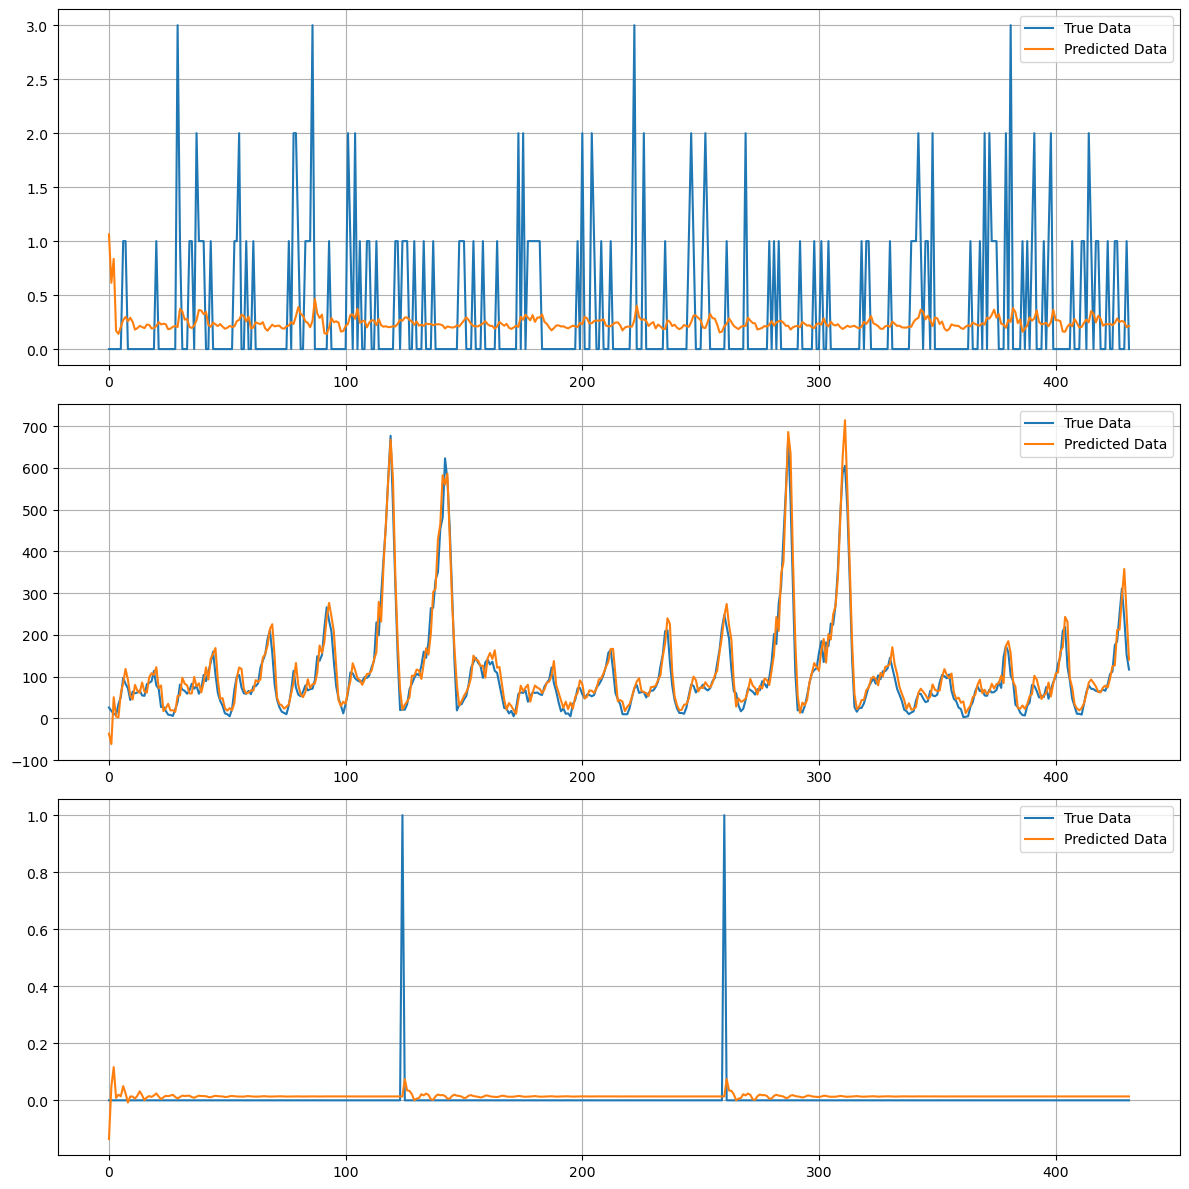

In [16]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_target = []

    for batch_X, batch_y in valid_loader:
        batch_X = batch_X.unsqueeze(dim=-1)
        batch_y = batch_y.unsqueeze(dim=-1)
        
        preds = model(zone_id_list, batch_X)
        
        test_preds.append(preds)
        test_target.append(batch_y)
         
    test_preds = torch.cat(test_preds, dim=-2)
    test_target = torch.cat(test_target, dim=-2)
    
    test_loss = criterion(test_preds, test_target)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Change the dimension to work with scaler
    test_preds = test_preds.numpy().squeeze(-1).T
    test_target = test_target.numpy().squeeze(-1).T
    
    # Inverse transform to get the original scale
    test_preds = scaler.inverse_transform(test_preds)
    test_target = scaler.inverse_transform(test_target)
    
    # Transpose again
    test_preds = test_preds.T
    test_target = test_target.T
    
    
    # Plot
    fig, axs = plt.subplots(len(zone_id_list), 1, figsize=(12, 12))
    for c in range(test_target.shape[0]):   
        axs[c].plot(range(test_target.shape[1]), test_target[c], label='True Data')
        axs[c].plot(range(test_target.shape[1]), test_preds[c], label='Predicted Data')
        axs[c].legend()
        axs[c].grid(True)
    plt.tight_layout()
    plt.show()


## LSTM

In [17]:
class LSTM_MultiSeries_Model(nn.Module):
    def __init__(self, embed_dim_inputs, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super(LSTM_MultiSeries_Model, self).__init__()
        self.cat_embed = nn.Embedding(embed_dim_inputs[0], embed_dim_inputs[1])
        # self.embed_dropout = nn.Dropout(0.4)
        self.lstm = nn.LSTM(embed_dim_inputs[1] + input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.h = [torch.zeros(num_layers, batch_size, hidden_size) for _ in range(2)]

    def forward(self, x_cat, x_cont):
        emb = self.cat_embed(x_cat)
        # Expand the embedding matrix to concatenate to the continuous times series
        emb_expanded = emb.unsqueeze(dim=-2).expand((-1, x_cont.size(-2), -1)) 
        # emb_expanded = self.embed_dropout(emb_expanded)
        x = torch.cat([emb_expanded, x_cont], dim=-1)
        out, h = self.lstm(x, self.h)
        self.h = [h_.detach() for h_ in h]
        out = self.fc(out)
        return out

    def reset(self): 
        for h in self.h: h.zero_()

In [18]:
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 1

zone_id_list = torch.tensor(sorted(list(ts_2['zone_id'].unique()))).long().to(device)
embed_dim_inputs = len(zone_id_list), min(50, (len(zone_id_list)+1)//2)
print('dimension', embed_dim_inputs)

model = LSTM_MultiSeries_Model(embed_dim_inputs, 
                               input_size,
                               hidden_size,
                               output_size,
                               num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)


dimension (3, 2)


In [19]:
# Training loop for multiple series RNN/LSTM
num_epochs = 1000

## to keep track of if validation loss went up
times_valid_loss_went_up_in_a_row = 0

## an initial value
min_valid_loss = float("inf")

valid_loss_list = []

for epoch in range(num_epochs):
    ## Train
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        
        batch_X = batch_X.unsqueeze(dim=-1)
        batch_y = batch_y.unsqueeze(dim=-1)

        preds = model(zone_id_list, batch_X)
        train_loss = criterion(preds, batch_y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    model.reset()

    ## Validate
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
        
            batch_X = batch_X.unsqueeze(dim=-1)
            batch_y = batch_y.unsqueeze(dim=-1)
            
            preds = model(zone_id_list, batch_X)
            valid_loss = criterion(preds, batch_y)

            epoch_valid_loss += valid_loss.item()
    
    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    model.reset()

    ## print out Train and Valiation loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')

    ## Early Stopping: check if the error went up or down
    valid_loss_list.append(avg_valid_loss)

    # if it went down
    if valid_loss_list[-1] < min_valid_loss:
        # record the new minimum val error
        min_valid_loss = valid_loss_list[-1]

        # reset our up counter
        times_valid_loss_went_up_in_a_row = 0
    # if it went up
    else:
        # add to the counter
        times_valid_loss_went_up_in_a_row = times_valid_loss_went_up_in_a_row + 1
        # if this is the 20th time in a row it has gone up
        if times_valid_loss_went_up_in_a_row == 20:
            # stop early
            break

Epoch [10/1000], Train Loss: 0.0111, Validation Loss: 0.0093
Epoch [20/1000], Train Loss: 0.0106, Validation Loss: 0.0091
Epoch [30/1000], Train Loss: 0.0105, Validation Loss: 0.0091


Test Loss: 0.0090


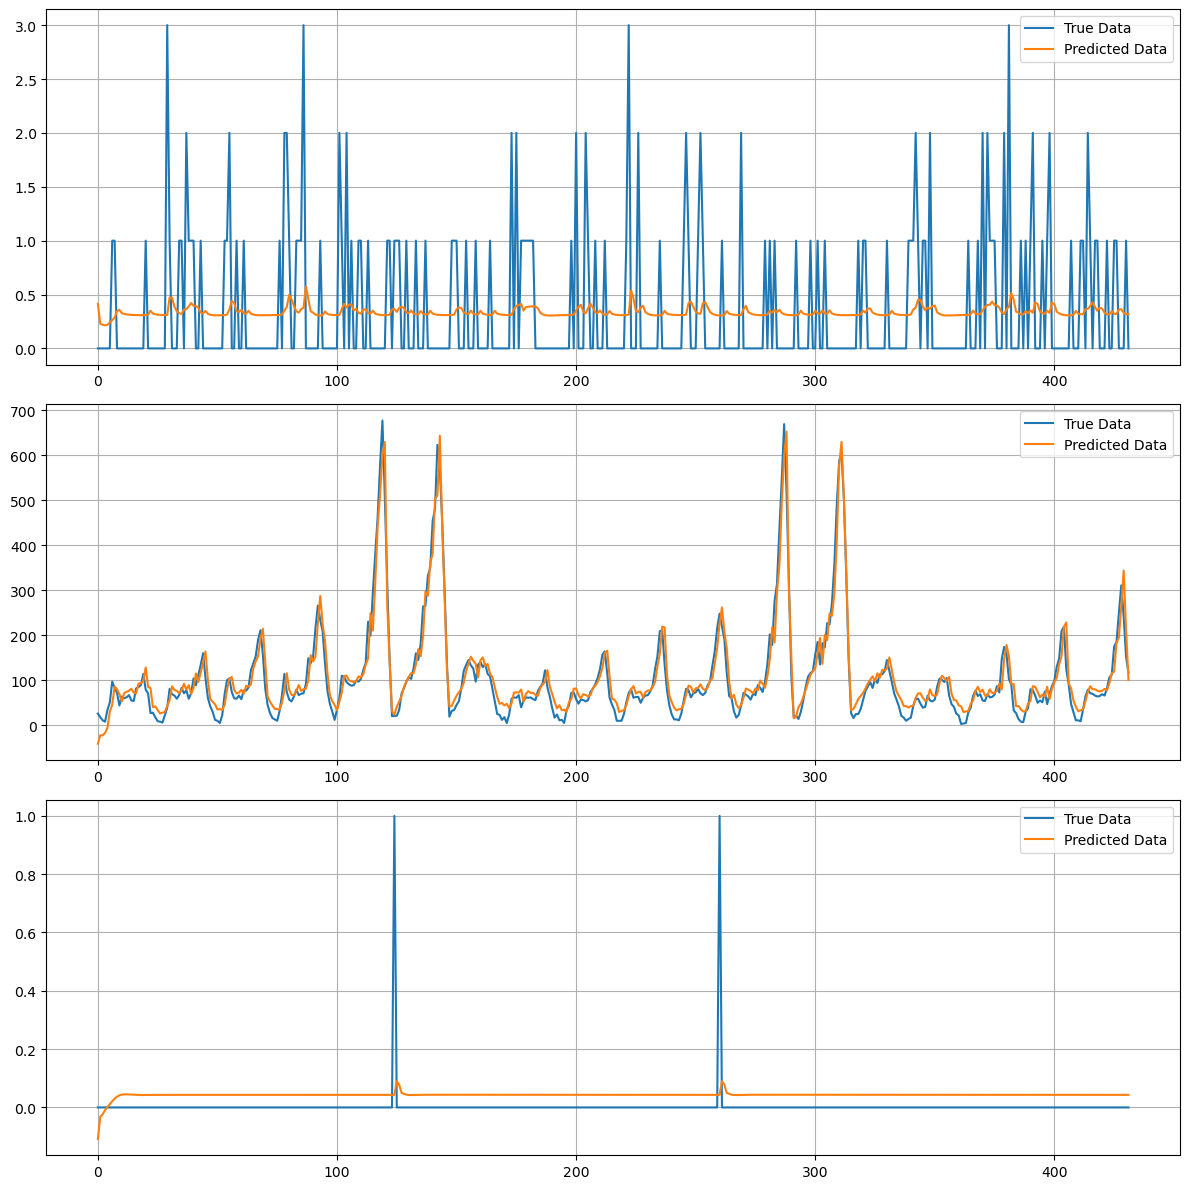

In [20]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_target = []

    for batch_X, batch_y in valid_loader:
        batch_X = batch_X.unsqueeze(dim=-1)
        batch_y = batch_y.unsqueeze(dim=-1)
        
        preds = model(zone_id_list, batch_X)
        
        test_preds.append(preds)
        test_target.append(batch_y)
         
    test_preds = torch.cat(test_preds, dim=-2)
    test_target = torch.cat(test_target, dim=-2)
    
    test_loss = criterion(test_preds, test_target)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Change the dimension to work with scaler
    test_preds = test_preds.numpy().squeeze(-1).T
    test_target = test_target.numpy().squeeze(-1).T
    
    # Inverse transform to get the original scale
    test_preds = scaler.inverse_transform(test_preds)
    test_target = scaler.inverse_transform(test_target)
    
    # Transpose again
    test_preds = test_preds.T
    test_target = test_target.T
    
    # Plot
    fig, axs = plt.subplots(len(zone_id_list), 1, figsize=(12, 12))
    for c in range(test_target.shape[0]):   
        axs[c].plot(range(test_target.shape[1]), test_target[c], label='True Data')
        axs[c].plot(range(test_target.shape[1]), test_preds[c], label='Predicted Data')
        axs[c].legend()
        axs[c].grid(True)
    plt.tight_layout()
    plt.show()
